# TP 2: Aymane El Firdoussi

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from scipy.stats import norm
# imports go here

In [2]:
fn1 = "Aymane"
ln1 = "El Firdoussi"
filename = "_".join(map(lambda s: s.strip().lower(),
                      ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"


## Question 1: Preprocessing the data

### 1-a) Fixing the random seed to 0

In [3]:
# Setting the random seed to 0
random.seed(0)

# Therefore, we will always get the same random value if we compute: random.random()

### 1-b) Loading the data and printing means and standard deviations

In [4]:
# Loading the data:
data = pd.read_csv("meatspec.csv")

#printing the mean of each covariate
data.mean()

V1       2.808561
V2       2.811137
V3       2.813727
V4       2.816363
V5       2.819098
          ...    
V97      3.081070
V98      3.062290
V99      3.043548
V100     3.024895
fat     18.142326
Length: 101, dtype: float64

In [5]:
# Printing the standard deviation of each covariate:
data.std()

V1       0.410793
V2       0.413352
V3       0.415906
V4       0.418465
V5       0.421040
          ...    
V97      0.539730
V98      0.538586
V99      0.537108
V100     0.535354
fat     12.740297
Length: 101, dtype: float64

### Interpretation:
The data is not centered since the mean is different from 0, nor it is standardized since standard deviations are not equal to 1. And all our data is not normalized since the values are not between 0 and 1. 

## 1-c) Separating the data into train and test sets 

In [6]:
# The import of train_test_split has been done in the first cell
X = data.drop(['fat'], axis=1)
y= data['fat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# The import of standard scaler has been done as well in the first cell
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_scaled = scaler.transform(y_test.to_numpy().reshape(-1,1))

In [7]:
# test if data is correctly standardized or not:
X_train_scaled.std()

1.0

## 1-d) Fitting a regular OLS:
The regular OLS is given by: 
$$ \theta = (X^TX)^{-1}X^T Y$$
We don't need to fit the intercept since the data is centered.
We can also use the Linear Regression model from the sklean.linear_model library.

In [8]:
# Computing the regular OLS estimator:
model = LinearRegression(fit_intercept=False)

# We fit the model to the training set
reg = model.fit(X_train_scaled,y_train_scaled)

# Prediction phase (test phase)
y_pred = reg.predict(X_test_scaled)
y_pred.shape

(54, 1)

#### 1-e) Computing the $R^2$ coefficients :
The $R^2$ can be calculated as follows:
 $$ R^2 = 1 - \frac{\| \hat{Y} - Y \|}{\| Y - \bar{y}_n \mathbb{1}_n\|} $$

 Where $ \hat{Y} $ is the predicted vector using our model, and $\mathbb{1}_n$ is the mean of the test vector y_test_scaled.

In [9]:
# Computing the R^2 coefficient for this OLS
def R2_coef(y, y_pred):
    Y_bar = np.mean(y)
    SSR = np.sum((y_pred - y) ** 2)
    SST = np.sum((y - Y_bar) ** 2)
    return 1 - SSR / SST

# Here we use the R2 given by the sklearn library
R2 = reg.score(X_train_scaled, y_train_scaled)

# Storing it into a dataframe
d = {'model': ['OLS'], 'R2': [R2]}
df_coef = pd.DataFrame(data=d)
df_coef

,model,R2
0,OLS,0.997472


## Question 2: Forward variable selection

The OLS $\theta_n(Y,X_k) = \arg \min_{\theta \in \mathbb{R}} \| Y - \theta X_k\|^2 $ is given by: (differentiating and finding the zero of the derivative)
$$ \theta_n(Y,X_k) = (X_k^T X_k)^{-1}X_k^T Y$$ 

In [10]:
# Define the statistic
def T(Y,X,k,n): # Y is a column vector, whereas X is our matrix
    Xk = X[:,k].reshape(-1,1)
    reg = LinearRegression().fit(Xk,Y)
    teta_n = reg.coef_[0]
    # inverse of Gram matrix
    G_1 = np.linalg.inv(Xk.T @ Xk)
    s_n = np.sqrt(G_1[0,0])
    sigma_n = (1/np.sqrt(n-2)) * np.linalg.norm(Y - reg.predict(Xk), 2) 
    return teta_n / (s_n * sigma_n)

# Forward variable selection algorithm
def forward_var_selection(X,Y): # X is a matrix, Y column vector and A the set of all columns of X
    n = X.shape[0]
    p = X.shape[1]
    r = Y.copy() 
    S = {} # the set of ordered features that we will get at the end, here it is a dictionary
    p_values = [] # the list of p-values

    #define the set of features
    A = list(range(0, p))

    while len(A) > 0 : 
        # Computing tests for all features
        values = np.zeros(p)
       
        for i in A : # columns left in A
            values[i] = abs(T(r, X, i, n))
        
        k_max = np.argmax(values)
        # computing the p-value associated with the value max
        p_value = 2*(1 - norm.cdf(abs(values[k_max])))
        p_values.append(p_value)

        # Adding the feature the maximizes the test T to S
        X_max = X[:, k_max].reshape(-1, 1)
        reg = LinearRegression().fit(X_max, r)
        S[k_max] = values[k_max]
        r = r - reg.predict(X_max)
        del A[A.index(k_max)]
    
    return S, p_values
  

In [11]:
# Preparing the data to use in forward variable selection
S,p_values = forward_var_selection(X_train_scaled,y_train_scaled) # 40, 7, 39, 6

# Now since features of our dataset are written as V'number +1', then we do the following
def features(l):
    V = []
    for i in l:
        V.append('V' + str(i + 1))
    return V 

# DataFrame with features and p values
d = {'index':S.keys(), 'feature': features(S.keys()), 'p_value': p_values}
df_var_sel = pd.DataFrame(data=d).set_index('index')
df_var_sel.head()

,feature,p_value
index,,
40,V41,5.180079e-12
6,V7,2.176395e-02
39,V40,2.318662e-02
7,V8,2.377254e-02
41,V42,2.646606e-02


## Question 3

### 3-a) Applying the OLS to features that have p value smaller than 0.05

In [12]:
# Selecting features with p value smaller than 0.05
mask = (df_var_sel['p_value'] < 0.05)
selected = df_var_sel.loc[mask].index.to_list()
selected

[40, 6, 39, 7, 41, 5, 38, 8, 42, 4, 37, 9]

In [13]:
# Applying OLS
reg = LinearRegression().fit(X_train_scaled[:,selected], y_train_scaled)
y_pred2 = reg.predict(X_test_scaled[:,selected])

### 3-b) Computing the $R^2$ coefficient for this model  

In [14]:
# R2 coefficient using sklearn
R2 = reg.score(X_train_scaled[:,selected], y_train_scaled)
df_coef.loc[1] = ['For_Var_Sel',R2]

In [15]:
df_coef

,model,R2
0,OLS,0.997472
1,For_Var_Sel,0.957028


## Question 4: Sequential Feature Selector

In [16]:
# Using the sequential feature selctor from sklearn.feature_selection
reg = LinearRegression()
sfs = SequentialFeatureSelector(reg, n_features_to_select = len(selected), direction = 'forward')
sfs.fit(X_train_scaled, y_train_scaled)

# Returning the selected features
selected_sfs = [i for i, x in enumerate(sfs.get_support()) if x == True]
selected_sfs

[29, 35, 37, 39, 40, 46, 47, 48, 50, 59, 98, 99]

### Observation:
We observe that the features selected by the SequentialFeatureSelector are not all the same as the ones chosen with the Forward Variable Selection algorithm. Which was expected since the stopping criterion is different in both methods. 
In fact, for the Forward Variable selection, the stopping criterion that we chose is the p value of the statistical test, which is not so accurate since we are using an asymptotical behaviour of the test, hence we need more data to be more accurate. Whereas the SequentialFeatureSelector compares the score for each possible feature addition or removal, and selects the one that results in the best improvement of the score.

### Computing the $R^2$ score for this new feature selection

In [17]:
# Applying OLS of new features
reg = LinearRegression().fit(X_train_scaled[:,selected_sfs], y_train_scaled)
y_pred3 = reg.predict(X_test_scaled[:,selected_sfs])

# R2 coefficient using sklearn
R2 = reg.score(X_train_scaled[:,selected_sfs], y_train_scaled)

# Adding the new value to the dataFrame df_coef
df_coef.loc[2] = ['Seq_Feat_Sel',R2]

In [18]:
df_coef

,model,R2
0,OLS,0.997472
1,For_Var_Sel,0.957028
2,Seq_Feat_Sel,0.974937


## Observation
We observe that the $R^2$ score for both methods remain close to each other, however we can say that the sequential Feature Selector method is more accurate than the Forward Variable selection.

## Ridge

## Question 5

The Ridge estimator is the solution of the following optimization problem:
$$ \hat{\theta}_n = \arg \min_{\theta \in \mathbb{R}^p} \| Y - X\theta\|^2 + \alpha \| \theta \|^2 $$
The function to minimize is $ \alpha $-strongly convex, hence the solution to this problem is unique and is given by:
$$ \hat{\theta}_n = (X^T X + \alpha I_p)^{-1} X^T Y$$
Where $X \in \mathbb{R}^{n x p}$ and $ Y \in \mathbb{R}^n $

In [19]:
# Programming the ridge estimator
def Ridge(X,Y,alpha):
    p = X.shape[1]
    return np.linalg.inv( X.T @ X + alpha* np.eye(p)) @ X.T @ Y

### 5 - (a)

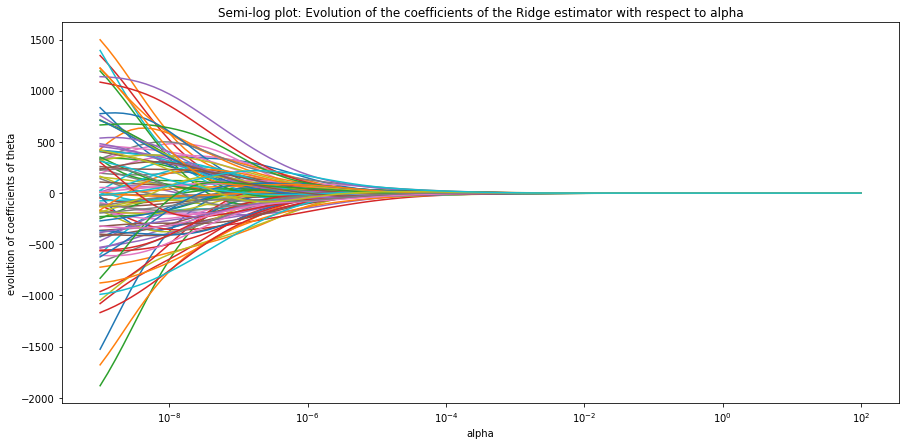

In [20]:
# Set of values of alpha
alpha_interval = np.logspace(np.log10(1e-9), np.log10(100), num=100)

# Computing the ridge estimators for each alpha and storing results in a list called estimators
estimators = Ridge(X_train_scaled, y_train_scaled, alpha_interval[0])

for alpha in alpha_interval[1:]:
    estimators = np.hstack((estimators,Ridge(X_train_scaled, y_train_scaled, alpha)))

# Plotting the evolution
plt.figure(figsize=(15,7))
for i in range(len(estimators)):
    plt.semilogx(alpha_interval, estimators[i])
plt.xlabel("alpha")
plt.ylabel("evolution of coefficients of theta")
plt.title("Semi-log plot: Evolution of the coefficients of the Ridge estimator with respect to alpha")
plt.show()

### Observation:
We observe that the Ridge estimator goes to zero when $\alpha$ is high. Which was expected since if $\alpha$ becomes large enough, we have that $\forall \theta \in \mathbb{R}^p$ : $$ \alpha \| \theta \|^2 + \| Y - X\theta \|^2 \geq  \| Y \|^2 $$ 
Hence, in that case: 0 is the unique solution to the problem.


### 5 - (b)

#### Computing the Mean Squared Errors for train and test sets

In [21]:
# Define the Mean Squared Error (MSE)
def MSE(y,y_pred):
    n = len(y)
    return np.sum( (y - y_pred)**2 ) / n

# MSE of training set and test set
MSE_train = []
MSE_test = []
for i in range(estimators.shape[1]):
    # Computing the predictions
    y_pred_train = X_train_scaled @ estimators[:,i].reshape(-1,1)
    y_pred_test = X_test_scaled @ estimators[:,i].reshape(-1,1)
    
    # Adding predictions to the lists
    MSE_train.append( MSE(y_train_scaled, y_pred_train) )
    MSE_test.append(MSE(y_test_scaled, y_pred_test))

argmin_train = np.argmin(MSE_train)
argmin_test = np.argmin(MSE_test)
min_train = min(MSE_train)
min_test = min(MSE_test)

#### Plotting the evolution of the Mean Squared Errors

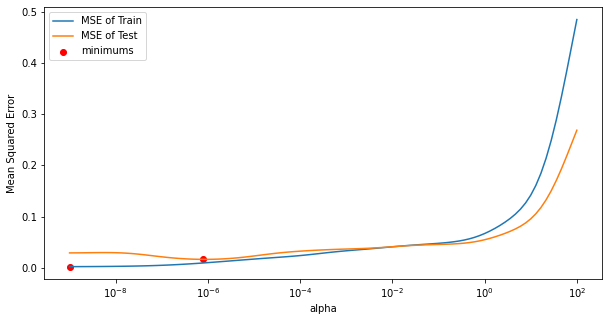

In [22]:
# Plotting the evolution of MSE
plt.figure(figsize = (10,5))
plt.semilogx(alpha_interval, MSE_train, label = 'MSE of Train')
plt.semilogx(alpha_interval, MSE_test, label = 'MSE of Test')
plt.scatter(alpha_interval[[argmin_train, argmin_test]], [min_train, min_test], c='r', label = 'minimums')
plt.xlabel("alpha")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

### Observation:
We conclude that the Mean squared errors increase with alpha exponentially.

### 5 - (c)

In [23]:
# The best alpha is the following
best_alpha = alpha_interval[argmin_train]

# Computing the R2 coefficient using the function that we defined in question 1
y_pred4 = X_test_scaled @ estimators[:,argmin_train].reshape(-1,1)
r2 = R2_coef(y_test_scaled, y_pred4)
print(r2)
# Adding this new coefficient to the Dataframe
df_coef.loc[3] = ['Ridge',r2]
df_coef

0.9497404494443065


,model,R2
0,OLS,0.997472
1,For_Var_Sel,0.957028
2,Seq_Feat_Sel,0.974937
3,Ridge,0.949740


## Cross-validation, Lasso and elastic net

## Question 6

### 6 - (a) Lasso model

In [107]:
# Interval of values of alpha in our Lasso model
L_alpha_interval = np.logspace(np.log10(1e-5), np.log10(1e-2), num=100)

# Creating two lists that will contain the predictions associated to each Lasso model
L_pred_train = []
L_pred_test = []

# Computing the Lasso estimator for each alpha and storing results in a list called estimators_L
lasso = Lasso(alpha = L_alpha_interval[0], max_iter = 1000000)
lasso.fit(X_train_scaled, y_train_scaled)
L_estimators = lasso.coef_.reshape(-1,1)
L_pred_train.append(lasso.predict(X_train_scaled))
L_pred_test.append(lasso.predict(X_test_scaled))

for alpha in L_alpha_interval[1:]:
    lasso = Lasso(alpha, max_iter = 1000000)
    lasso.fit(X_train_scaled, y_train_scaled)
    L_estimators = np.hstack((L_estimators,lasso.coef_.reshape(-1,1)))
    
    # Predictions
    L_pred_train.append(lasso.predict(X_train_scaled))
    L_pred_test.append(lasso.predict(X_test_scaled))


/Users/aelfirdo/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e+00, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aelfirdo/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.388e-01, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aelfirdo/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

KeyboardInterrupt: 

### Interpretation on warnings

Since the Lasso algorithm performs a descent algorithm on the function:
$$ \label{LASSO} \tag{LASSO} \theta \longrightarrow \| Y - X\theta\|^2 + \alpha \| \theta\|_1 $$ 
Because this equation does not have a unique solution, then we need to satisfy a compromise between tol, the precision, and max_iter, the maximum number of iterations of the algorithm n order to obtain a satisfying solution.

### 6 - (b) Plotting the evolution of coefficients with $\alpha$

In [95]:
L_estimators.shape

(100, 100)

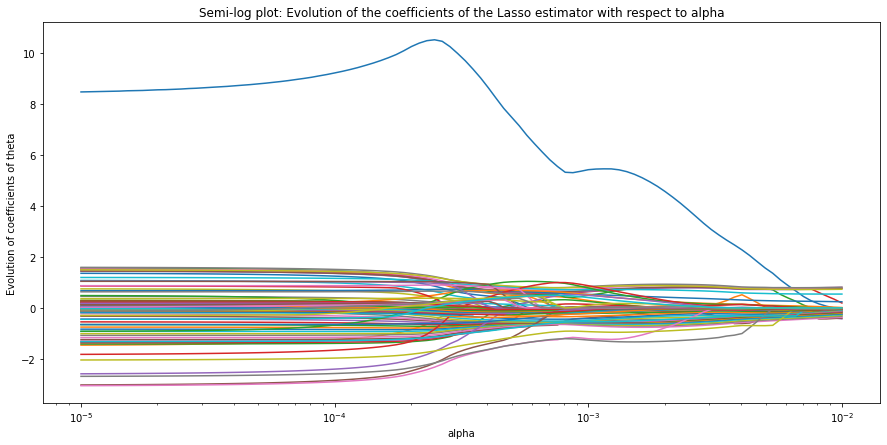

In [96]:
# Plotting the evolution of Lasso estimator
plt.figure(figsize=(15,7))
for i in range(len(L_estimators)):
    plt.semilogx(L_alpha_interval, L_estimators[i])
plt.xlabel("alpha")
plt.ylabel("Evolution of coefficients of theta")
plt.title("Semi-log plot: Evolution of the coefficients of the Lasso estimator with respect to alpha")
plt.show()

### The number of non-nul coefficients for each $\alpha$

In [97]:
# Plotting the number of non-null coefficients for each alpha
count = []
for i in range(L_estimators.shape[1]):
    # indices of non-null coefficients in each theta
    non_nul = [j for j, x in enumerate(L_estimators[:,i]) if abs(x) > 0] 
    count.append(len(non_nul))
   

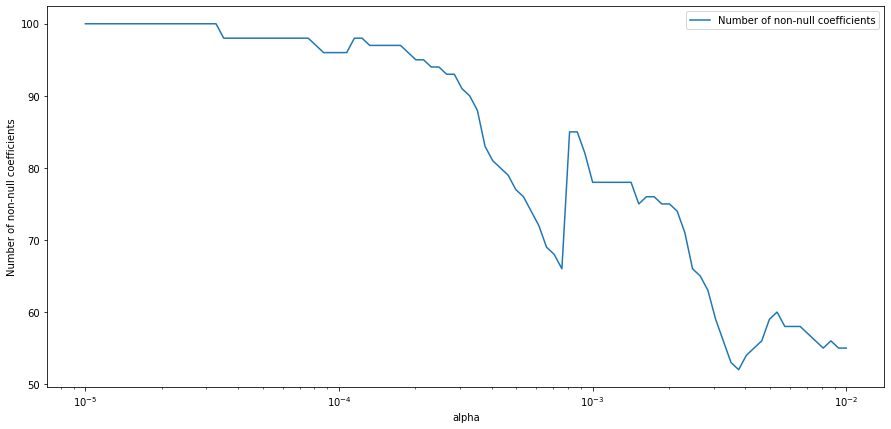

In [98]:
# Plotting  
plt.figure(figsize=(15,7))
plt.semilogx(L_alpha_interval, count, label = 'Number of non-null coefficients')
plt.xlabel('alpha')
plt.ylabel('Number of non-null coefficients')
plt.legend()
plt.show()

### Observation
We observe that the number of null coefficients increases with $\alpha$. Which can be explained as follows:
We know that (chapter 5 in the course SD-TSIA204) minimizing (\ref{LASSO}) with respect to the k-th coordinate is the same as minimizing :
$$ \frac{1}{2}(\langle z_k, \frac{X_k}{\| X_k\|^2} \rangle - \theta_k)^2 + \frac{\alpha}{\| X_k\|^2} |\theta_k| $$ 
Hence, the update is :
$$ \hat{\theta_k} = \eta_{\alpha / \| X_K\|^2} (\langle z_k, \frac{X_k}{\| X_k\|^2} \rangle) $$
Where $\eta_{\lambda}$ is the Soft thresholding function, which is given by:
$$\eta_{\lambda}(x) = 
\begin{cases}
x + \lambda & \text{if } x < - \lambda \\
0 & \text{if } x \in [- \lambda, \lambda] \\
x - \lambda & \text{if } x > \lambda
\end{cases}$$

Therefore, we observe that when $\alpha$ increases, the fraction $ \frac{\alpha}{\| X_K\|^2}$ becomes larger, and then the inner product $ \langle z_k, \frac{X_k}{\| X_k\|^2} \rangle $ is more likely to get in the interval $ [-\frac{\alpha}{\| X_K\|^2}, \frac{\alpha}{\| X_K\|^2} ] $, and in that case $ \hat{\theta}_k = 0$.

### 6 - (c) Computing the Mean Squared Errors for train and test sets and plotting their evolution with $\alpha$

In [103]:
# MSE of training set and test set
L_MSE_train = []
L_MSE_test = []

for i in range(len(L_pred_train)):
    L_MSE_train.append(MSE(y_train_scaled, L_pred_train[i]))
    L_MSE_test.append(MSE(y_test_scaled, L_pred_test[i]))
                     
L_argmin_train = np.argmin(L_MSE_train)
L_argmin_test = np.argmin(L_MSE_test)
L_min_train = min(L_MSE_train)
L_min_test = min(L_MSE_test)

### Evolution of the MSE

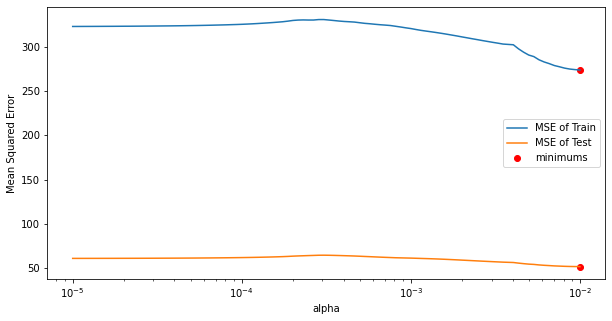

In [104]:
# Plotting the evolution of MSE
plt.figure(figsize = (10,5))
plt.semilogx(L_alpha_interval, L_MSE_train, label = 'MSE of Train')
plt.semilogx(L_alpha_interval, L_MSE_test, label = 'MSE of Test')
plt.scatter(L_alpha_interval[[L_argmin_train, L_argmin_test]], [L_min_train, L_min_test], c='r', label = 'minimums')
plt.xlabel("alpha")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

### 6 - (d) $R^2$ fot the best performing value of $\alpha$

In [110]:
# The best alpha is the following
L_best_alpha = L_alpha_interval[L_argmin_train]
print("The best performing value of alpha for Lasso is ",L_best_alpha)

# Computing the R2 coefficient using the function that we defined in question 1
lasso = Lasso(alpha = L_best_alpha, tol = 1e-3, max_iter = 100000).fit(X_train_scaled, y_train_scaled)
y_pred5 = lasso.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, y_pred5)

# Adding this new coefficient to the Dataframe
df_coef.loc[4] = ['Lasso',r2]
df_coef

The best performing value of alpha for Lasso is  0.01


,model,R2
0,OLS,0.997472
1,For_Var_Sel,0.957028
2,Seq_Feat_Sel,0.974937
3,Lasso,-87.905756
4,Lasso,0.872779
